<a href="https://colab.research.google.com/github/amohd63/ENCS5141-INTELLIGENT-SYSTEMS-LAB/blob/main/ENCS5141_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
A = 1
B = 9
C = 0
D = 5
Y = 0
X = 2
ABC = 190

tau = (1 + A + B + C + D + Y) / 7  # Threshold

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, X + 4, kernel_size=3)
    self.pool1 = nn.AvgPool2d(2, stride=2)

    self.conv2 = nn.Conv2d(X + 4, Y + 15, kernel_size=3)
    self.pool2 = nn.AvgPool2d(2, stride=2)

    self.fc1 = nn.Linear((Y + 15) * 5 * 5, 190)

    self.fc2 = nn.Linear(190, 16)

    self.fc3 = nn.Linear(16, 1)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.sigmoid(self.fc3(x))

    return x

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 370249719.43it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 54664121.76it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 206087710.73it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8990339.20it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Instantiate the model, loss function, and optimizer
model = CustomCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [5]:
# Move model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 3
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        labels_binary = (labels > tau).float()
        loss = criterion(outputs, labels_binary.view(-1, 1))
        loss.backward()
        optimizer.step()

        predictions = (outputs > 0.5).float()

        total_correct += (predictions == labels_binary.view(-1, 1)).sum().item()
        total_samples += labels.size(0)

        if (batch_idx + 1) % 2000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_accuracy = total_correct / total_samples
    train_accuracies.append(train_accuracy)
    print(f'Training Accuracy after Epoch {epoch + 1}: {train_accuracy:.4f}')

Epoch [1/3], Step [2000/7500], Loss: 0.0247
Epoch [1/3], Step [4000/7500], Loss: 0.2823
Epoch [1/3], Step [6000/7500], Loss: 0.0857
Training Accuracy after Epoch 1: 0.9638
Epoch [2/3], Step [2000/7500], Loss: 0.0013
Epoch [2/3], Step [4000/7500], Loss: 0.7210
Epoch [2/3], Step [6000/7500], Loss: 0.0048
Training Accuracy after Epoch 2: 0.9897
Epoch [3/3], Step [2000/7500], Loss: 0.0002
Epoch [3/3], Step [4000/7500], Loss: 0.0010
Epoch [3/3], Step [6000/7500], Loss: 0.0059
Training Accuracy after Epoch 3: 0.9928


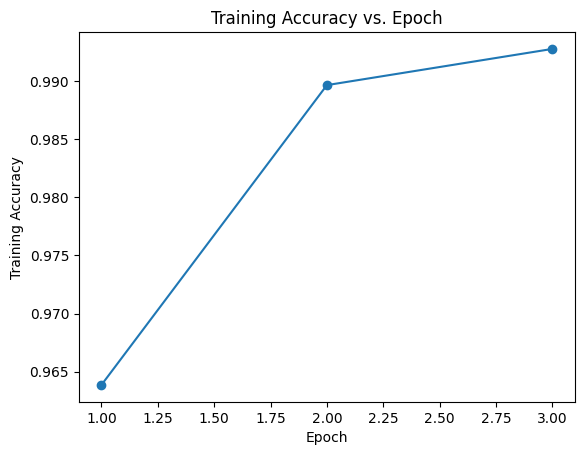

Test Accuracy: 0.9918


In [19]:
# Plot training accuracy vs. epoch curve
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o')
plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.show()

In [20]:
# Evaluation on the test set
model.eval()
test_correct = 0
test_total = 0
misclassified_images = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        predictions = (outputs > 0.5).float()
        test_correct += (predictions == (labels > tau).float().view(-1, 1)).sum().item()
        test_total += labels.size(0)

        # Track misclassified images
        for i in range(len(labels)):
            if predictions[i] != (labels[i] > tau).float():
                misclassified_images.append((data[i].cpu(), labels[i], predictions[i].item()))

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9918


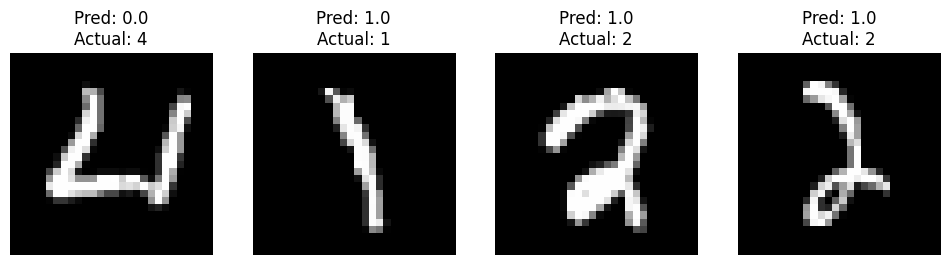

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, (image, true_label, predicted_label) in enumerate(misclassified_images[:4]):
    axes[i].imshow(image[0], cmap='gray')
    axes[i].set_title(f'Pred: {predicted_label}\nActual: {true_label}')
    axes[i].axis('off')

plt.show()